# Advanced solar irradiance course part II: Forecasting of solar irradiance

### In this part of the course we will continue with statistical learning and give a brief introduction into machine learning. The main difference between the two lies in their purpose: while statistical learning aims to infer the relationship between variables and has the ability to make predictions, machine learning aims to accurately predict while offering less interpretability. 

### As the following article will show, my explanation was too brief but he makes the distinction very clear! (15 min read)

In [1]:
%%html
<iframe src="https://towardsdatascience.com/the-actual-difference-between-statistics-and-machine-learning-64b49f07ea3" width="950" height="500"></iframe>

### Today's outline:

### 1) Motivate why we are interested in probabilistic forecasting.

### 2) Introduce a few verification tools that we need to assess probabilistic forecasts.

### 3) Introduce cross-validation, training and testing in machine learning.

### 4) An introduction to regression and some examples.

### 5) An introduction machine learning and some examples.

### 6) A brief look at data cleaning and data analysis.

## So, let's start with why we are interested in probabilistic forecasting by visualizing some irradiance data from Desert Rock, Nevada. These data are freely available from the National Renewable Energy Laboratory (NREL) through an API, but these are downloaded already.

In [2]:
import numpy as np
import pandas as pd
dat = pd.read_csv("/Users/Dennis/Desktop/SupplementaryMaterials/data/dra_2015-2016.txt", delimiter = "\t",
                 header='infer')
dat['Time'] = pd.to_datetime(dat['Time']) # Make sure that pandas recognizes this as datetime
dat = dat.set_index('Time') # Set time column as the index (easier for plotting)
dat.head()

,zen,dw_solar,G_pers,Ics,G_psm,G_nam
Time,,,,,,
2015-01-01 00:00:00,85.723,60.178,59.847,50.645,72,NaN
2015-01-01 01:00:00,94.665,0.775,0.293,0.034,0,NaN
2015-01-01 02:00:00,105.941,0.000,0.000,0.000,0,NaN
2015-01-01 03:00:00,117.636,0.000,0.000,0.000,0,NaN
2015-01-01 04:00:00,129.599,0.000,0.000,0.000,0,NaN


### Let's plot this to see what we're dealing with

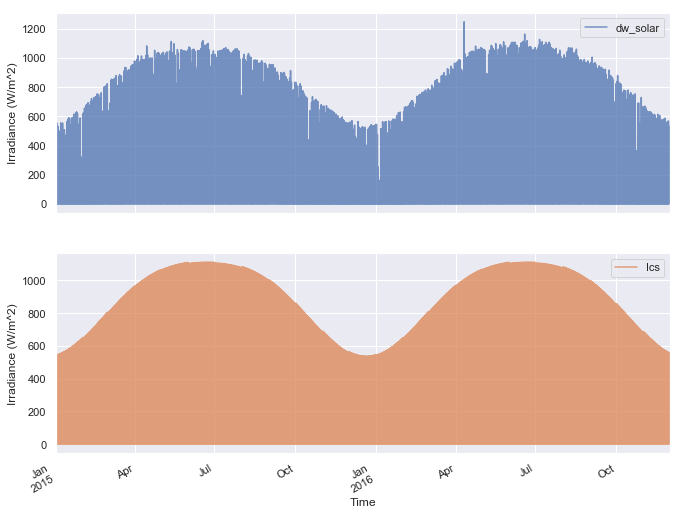

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

cols_plot = ['dw_solar', 'Ics']
axes = dat.loc['2015-01-01 00:00:00':'2016-12-01 00:00:00',cols_plot].plot(alpha=0.75, figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Irradiance (W/m^2)')


### We can clearly observe the daily variability in the top figure while we see the seasonal variability in the bottom figure. Let's zoom in a bit further:

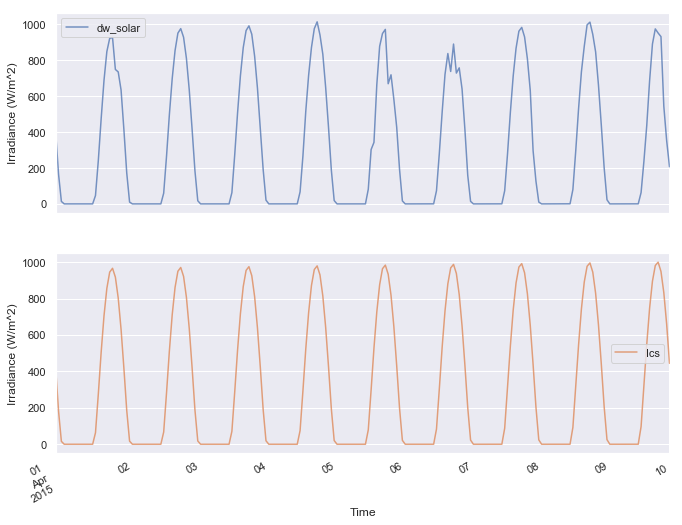

In [5]:
cols_plot = ['dw_solar', 'Ics']
axes = dat.loc['2015-04-01 00:00:00':'2015-04-10 00:00:00',cols_plot].plot(alpha=0.75, figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Irradiance (W/m^2)')

### Notice how little variability this time series contains, which is due to its geographical location. Let's see what happens when we load irradiance data from the same period but then from Sioux Falls, South Dakota.

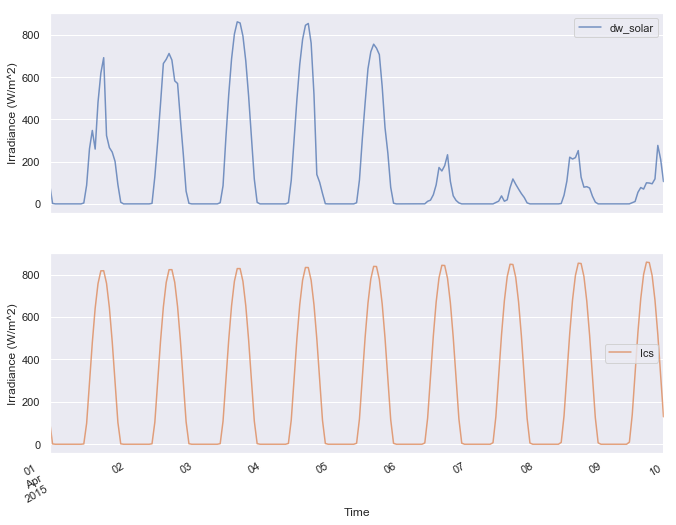

In [6]:
dat = pd.read_csv("/Users/Dennis/Desktop/SupplementaryMaterials/data/sxf_2015-2016.txt", delimiter = "\t",
                 header='infer')
dat['Time'] = pd.to_datetime(dat['Time']) # Make sure that pandas recognizes this as datetime
dat = dat.set_index('Time') # Set time column as the index (easier for plotting)
cols_plot = ['dw_solar', 'Ics']
axes = dat.loc['2015-04-01 00:00:00':'2015-04-10 00:00:00',cols_plot].plot(alpha=0.75, figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Irradiance (W/m^2)')

### This dataset also contains numerical weather prediction (NWP) forecasts, which is an important input when forecasting more than 6 hours into the future (more on that later). Let's first compare these forecasts with the actual irradiance at Sioux Falls again:

Text(0, 0.5, 'Irradiance (W/m^2)')

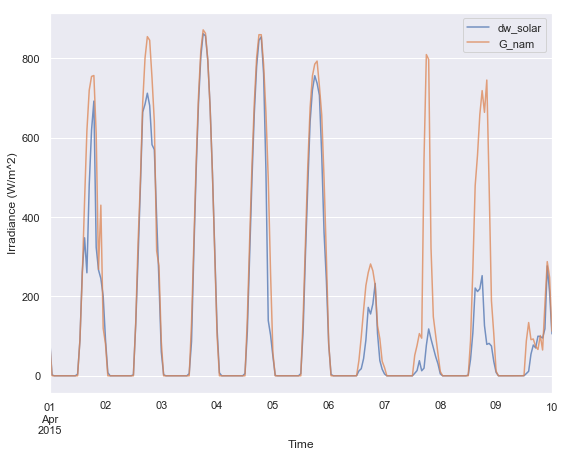

In [7]:
cols_plot = ['dw_solar', 'G_nam']
axes = dat.loc['2015-04-01 00:00:00':'2015-04-10 00:00:00',cols_plot].plot(alpha=0.75, figsize=(9, 7), subplots=False)
axes.set_ylabel('Irradiance (W/m^2)')

### In addition to NWP forecasts, this data set also contains the persistence forecasts. The persistence forecast is an important benchmark in solar forecasting because it does not have 'skill'. The reason for this is that the persistence forecast is simply the current observation, e.g., the forecast for one hour or one day ahead is the weather (irradiance/temperature/etc.) I observe now.

A plot generally makes it easier to understand:

Text(0, 0.5, 'Irradiance (W/m^2)')

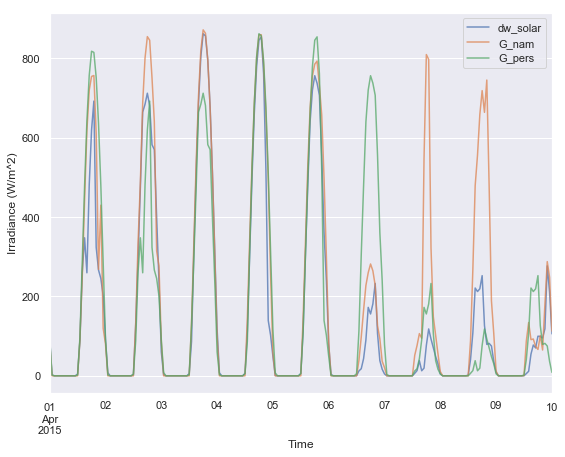

In [8]:
cols_plot = ['dw_solar', 'G_nam', 'G_pers']
axes = dat.loc['2015-04-01 00:00:00':'2015-04-10 00:00:00',cols_plot].plot(alpha=0.75, figsize=(9, 7), subplots=False)
axes.set_ylabel('Irradiance (W/m^2)')

### The strategy of plotting the data as a time series is a bit cumbersome, more effective would be to plot a scatterplot of the forecasts versus the observations. This reveals all time-independent information of the forecasts.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e0186a0>,
      dtype=object)

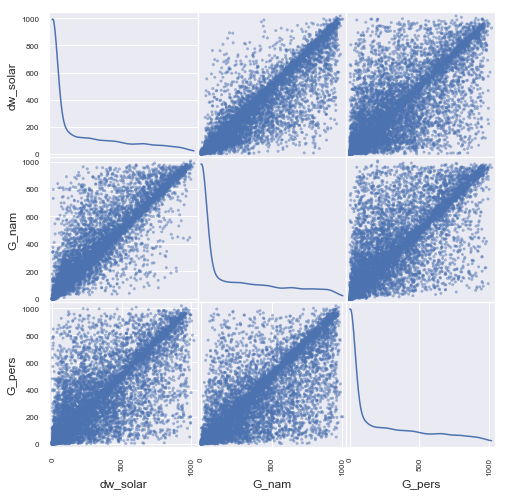

In [9]:
from pandas.plotting import scatter_matrix
scatter_matrix(dat[['dw_solar','G_nam', 'G_pers']], alpha=0.5, figsize=(8, 8), diagonal='kde')

### The former plot reveals a systematic negative bias of the NWP forecast model, i.e.,  it tends to underestimate the irradiance. 
This is quite a common feature of NWP models and an entire field is dedicated to solving these issue (called postprocessing). However, by mapping irradiance to PV power through a non-linear function, e.g., a machine learning model, we implicitly postprocess the NWP forecast.
### The main point of these plots was to make the case for probabilistic forecasting, since future irradiance is a random variable and a forecast of the mean gives an incomplete picture of future irradiance. Furthermore, there are uncertainties in the data we have observed (e.g., sensor noise), the model that we have selected (are the model assumptions realistic enough?) and the model parameters that we have learned from our training data.
Additionally, it allows us to improve our decision making, e.g., should I bring an umbrella when there's only a 15% chance of rain or how can I optimally schedule EV charging given a number of irradiance scenarios? Obviously, there are many more use cases, especially related to (optimal) control.

## Some notation:

Let $y_i$ be the observed data during period $i$, $i=1,\ldots,N$, i.e., $\mathbf{y} = \left(y_1, y_2, \ldots, y_N\right)^T$. There is some function $f$ that maps $x_i$ to $y_i$ as: $y_i = f(x_i) + \epsilon_i$, where $\epsilon_i$ is i.i.d. $\mathcal{N}(0,\sigma^2)$. In words this means that there exists a (non-)linear function $f$ that allows us to directly relate $x$ to $y$ while removing noise from the true signal. It is the function $f$ that we try to learn from the data.

### Data organization in a machine-learning setting:

In order to be able to learn $f$, we first need to organize our data set such that we have an $n \times p$ training matrix containing $n$ observations of $p$ input variables / features / dependent variables. This needs to be combined with an observation vector of length $n$. This is formulated as follows:

$\textbf{X}_{\text{train}}$ = 
\begin{bmatrix}
    x_{1,1} & x_{1,2} & x_{1,3} & \dots  & x_{1,p} \\
    x_{2,1} & x_{2,2} & x_{2,3} & \dots  & x_{2,p} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{n,1} & x_{n,2} & x_{n,3} & \dots  & x_{n,p}
\end{bmatrix}

$\textbf{y}_{\text{train}} = \left(y_1, y_2, \ldots, y_n\right)^T$

$\textbf{y}_{\text{train}} = \textbf{X}_{\text{train}}$

#### The simplest model would be a line, which is exactly what linear regression is. 
The observation vector $\textbf{y}_{\text{train}}$ and feature matrix $\textbf{X}_{\text{train}}$ are then related through parameters $\mathbf{\beta} = \left(\beta_1, \beta_2, \ldots, \beta_p\right)$ as follows: 
$\textbf{y}_{\text{train}} = \textbf{X}_{\text{train}} \cdot \mathbf{\beta}$.
We can find the $p+1$ parameters of the linear regression model by minimizing the sum of squared errors (SSE):
$L(\beta) = \sum^n_{i=1} | y_i - \sum_{j=1}^p X_{ij}\beta_j |^2$ = $\| \textbf{y}_{\text{train}} - \textbf{X}_{\text{train}} \cdot \mathbf{\beta} \|^2$. We have now estimated the parameters to compute the $\textit{conditional mean}$.

### Once the model has been identified and the parameters have been learned, we can use our function on a test set that we held out from the training set to make predictions:

$\textbf{X}_{\text{test}}$ = 
\begin{bmatrix}
    x_{n+1,1} & x_{n+1,2} & x_{n+1,3} & \dots  & x_{n+1,p} \\
    x_{n+2,1} & x_{n+2,2} & x_{n+2,3} & \dots  & x_{n+2,p} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{N,1} & x_{N,2} & x_{N,3} & \dots  & x_{N,p}
\end{bmatrix}

$\mathbf{\hat{y}}_{\text{pred}} = \textbf{X}_{\text{test}} \cdot \hat{\mathbf{\beta}} = \left(\hat{y}_{n+1}, \hat{y}_{n+2}, \ldots, \hat{y}_N\right)^T$

### Error metrics:
The sum of squared errors (SSE) is closely related to one of the most common error metrics: the root mean squared error. It has many advantages such as that it penalizes outliers more severely (which is what you'd want in forecasting) and that is has the same unit as the dependent variable. It is defined as RMSE = $\sqrt{\frac{1}{N-n+1}\sum^N_{i=n+1} (y_i - \hat{y}_i)^2}$. Another common metric is the mean absolute error (MAE): $\frac{1}{N-n+1}\sum^N_{i=n+1} |y_i - \hat{y}_i|$.

### Now that we formally have defined the training and test sets and two deterministic error metrics, we can introduce cross-validation (CV). 
Regression and machine learning models have the tendency to "overfit" to the training data when our sole objective is to minimize some loss function, as we will now see using linear regression. In order to achieve that, we generate some random data and generate a cubic function from that with additional noise. Then, we fit a linear function to the data and compare this to when we fit a function that is linear in the parameters but non-linear in the input variables (and therefore still linear regression):

RMSE = 10.126086012636929
$R^2$ = 0.2739710772044045


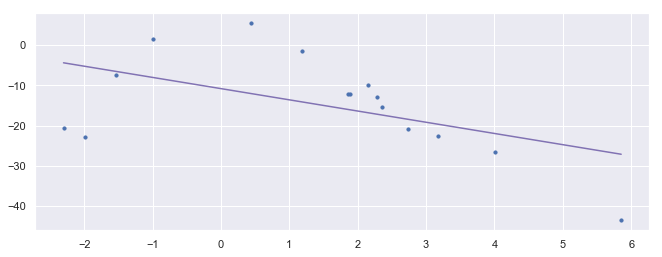

In [10]:
# Code adapted from: https://towardsdatascience.com/polynomial-regression-bbe8b9d97491

import operator

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(123)
x = 1 - 2 * np.random.normal(0, 1, 15)
y = x - 3 * (x ** 2) + 0.25 * (x ** 3) + np.random.normal(-2, 3.5, 15)

# transforming the data to include another axis
x = x[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=1)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print("RMSE =",rmse)
print("$R^2$ =",r2)

plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m', label='df = 1')
plt.legend()
plt.show()

In [31]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(df):
    np.random.seed(123)
    x = 1 - 2 * np.random.normal(0, 1, 15)
    y = x - 3 * (x ** 2) + 0.25 * (x ** 3) + np.random.normal(-2, 3.5, 15)

    # transforming the data to include another axis
    x = x[:, np.newaxis]

    polynomial_features= PolynomialFeatures(degree=df)
    x_poly = polynomial_features.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)
    
    rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
    r2 = r2_score(y,y_poly_pred)
    print("RMSE =",rmse)
    print("R^2 =",r2)
    
    plt.scatter(x, y, s=10)
    # sort the values of x before line plot
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
    x, y_poly_pred = zip(*sorted_zip)
    plt.plot(x, y_poly_pred, color='m', label=('df = '+str(df)))
    plt.legend()
    plt.show()

interactive_plot = interactive(f, df=(1, 15))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=8, description='df', max=15, min=1), Output(layout=Layout(height='350px'…

### As we can see, we can increase the number of degrees of our polynomial to improve the fit to the training. However, this does not mean that our model performs better on unseen data. In fact, it is quite the opposite, which is why we need to train on multiple slices of our training data and validate (test) how the model "generalizes".

In [32]:
%%html
<iframe src="https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Purpose_of_cross-validation" width="950" height="500"></iframe>

### Due to the autocorrelation in time series data, K-fold CV is not appropriate. 
Luckily, scikit offers TimeSeriesSplit (R has a similar feature in the $\texttt{caret}$ package). Below is a visualization of the way the time series is split up when performing cross-validation. Code from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py

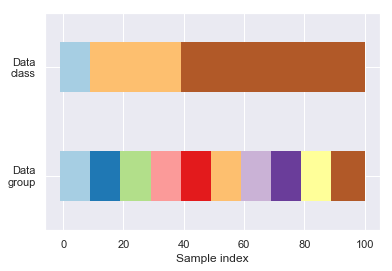

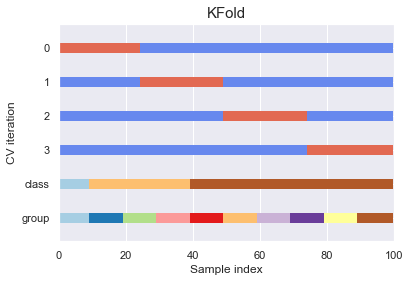

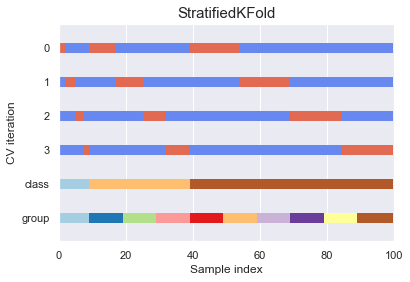

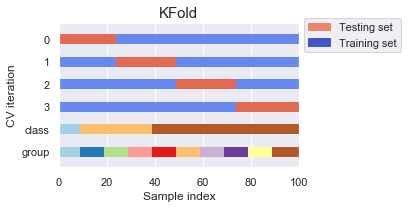

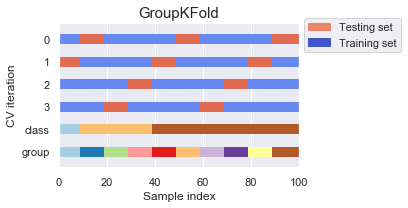

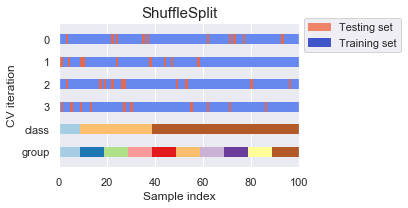

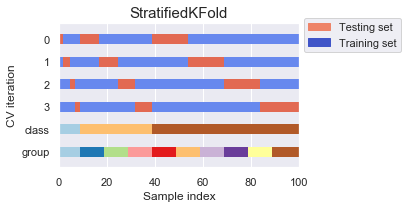

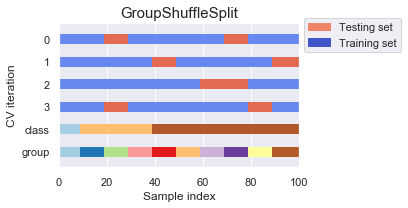

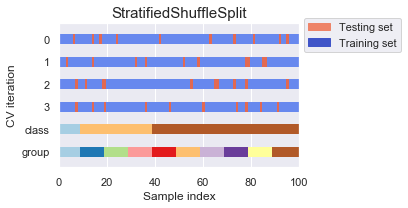

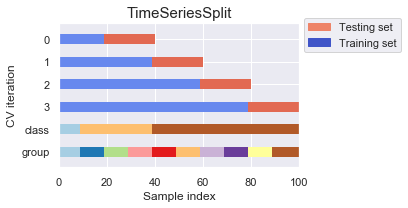

In [33]:
"""
Visualizing cross-validation behavior in scikit-learn
=====================================================

Choosing the right cross-validation object is a crucial part of fitting a
model properly. There are many ways to split data into training and test
sets in order to avoid model overfitting, to standardize the number of
groups in test sets, etc.

This example visualizes the behavior of several common scikit-learn objects
for comparison.
"""

from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
np.random.seed(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

###############################################################################
# Visualize our data
# ------------------
#
# First, we must understand the structure of our data. It has 100 randomly
# generated input datapoints, 3 classes split unevenly across datapoints,
# and 10 "groups" split evenly across datapoints.
#
# As we'll see, some cross-validation objects do specific things with
# labeled data, others behave differently with grouped data, and others
# do not use this information.
#
# To begin, we'll visualize our data.

# Generate the class/group data
n_points = 100
X = np.random.randn(100, 10)

percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc)
               for ii, perc in enumerate(percentiles_classes)])

# Evenly spaced groups repeated once
groups = np.hstack([[ii] * 10 for ii in range(10)])


def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(range(len(groups)),  [.5] * len(groups), c=groups, marker='_',
               lw=50, cmap=cmap_data)
    ax.scatter(range(len(groups)),  [3.5] * len(groups), c=classes, marker='_',
               lw=50, cmap=cmap_data)
    ax.set(ylim=[-1, 5], yticks=[.5, 3.5],
           yticklabels=['Data\ngroup', 'Data\nclass'], xlabel="Sample index")


visualize_groups(y, groups, 'no groups')

###############################################################################
# Define a function to visualize cross-validation behavior
# --------------------------------------------------------
#
# We'll define a function that lets us visualize the behavior of each
# cross-validation object. We'll perform 4 splits of the data. On each
# split, we'll visualize the indices chosen for the training set
# (in blue) and the test set (in red).


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


###############################################################################
# Let's see how it looks for the `KFold` cross-validation object:

fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

###############################################################################
# As you can see, by default the KFold cross-validation iterator does not
# take either datapoint class or group into consideration. We can change this
# by using the ``StratifiedKFold`` like so.

fig, ax = plt.subplots()
cv = StratifiedKFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

###############################################################################
# In this case, the cross-validation retained the same ratio of classes across
# each CV split. Next we'll visualize this behavior for a number of CV
# iterators.
#
# Visualize cross-validation indices for many CV objects
# ------------------------------------------------------
#
# Let's visually compare the cross validation behavior for many
# scikit-learn cross-validation objects. Below we will loop through several
# common cross-validation objects, visualizing the behavior of each.
#
# Note how some use the group/class information while others do not.

cvs = [KFold, GroupKFold, ShuffleSplit, StratifiedKFold,
       GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit]


for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=.7)
plt.show()


### There are other ways to prevent overfitting. A common approach is regularization, which adds a penalty (regularization) term to the loss function. Common regularizers are the least absolute shrinkage and selection operator (LASSO) and ridge regression. We will not go into these methods but below is a link to the Wikipedia page on the LASSO.

In [34]:
%%html
<iframe src="https://en.wikipedia.org/wiki/Lasso_(statistics)" width="950" height="500"></iframe>

### Now that we have introduced all necessary aspects, we can combine these and try to produce our first forecast.
Let's start with the simplest model (linear regression, which we have seen earlier) and apply it to the irradiance data of Sioux Falls, South Dakota.

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

dat = pd.read_csv("/Users/Dennis/Desktop/SupplementaryMaterials/data/sxf_2015-2016.txt", delimiter = "\t",
                 header='infer')
dat['Time'] = pd.to_datetime(dat['Time']) # Make sure that pandas recognizes this as datetime
dat = dat.set_index('Time') # Set time column as the index (easier for plotting)
dat = dat.dropna(axis=0) # Remove the NaNs

# Define the training and test set:
X_train = dat.loc['2015-01-01':'2016-01-31', 'Ics':'G_nam']
y_train = dat.loc['2015-01-01':'2016-01-31', 'dw_solar']

X_test = dat.loc['2016-02-01':'2016-12-31', 'Ics':'G_nam']
y_test = dat.loc['2016-02-01':'2016-12-31', 'dw_solar']

model = LinearRegression().fit(X_train,y_train)
y_hat = model.predict(X_test)

idx = y_test.to_numpy().nonzero()[0] # Check the non-zero values and disregard the rest
rmse = np.sqrt(mean_squared_error(y_test[idx],y_hat[idx]))
mae = mean_absolute_error(y_test[idx],y_hat[idx])
r2 = r2_score(y_test[idx],y_hat[idx])

print('MAE =',mae)
print('RMSE =',rmse)
print('r2 =',r2)

MAE = 43.92189289893975
RMSE = 69.57030385067777
r2 = 0.9378560561084929


In [37]:
# Compare this to the NWP forecast:
idx = y_test.to_numpy().nonzero()[0] # Check the non-zero values and disregard the rest
y_test = dat.loc['2016-02-01':'2016-12-31', 'G_nam']
rmse = np.sqrt(mean_squared_error(y_test[idx],y_hat[idx]))
mae = mean_absolute_error(y_test[idx],y_hat[idx])
r2 = r2_score(y_test[idx],y_hat[idx])
print('MAE =',mae)
print('RMSE =',rmse)
print('r2 =',r2)

MAE = 69.39901266663853
RMSE = 119.71921264347708
r2 = 0.8285535870706227


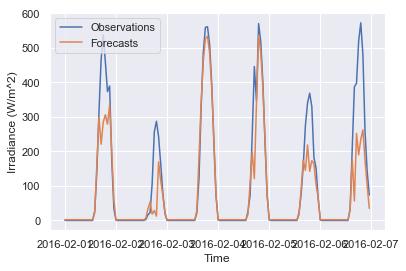

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

y_hat = pd.Series(y_hat, index = y_test.index)

fig, ax = plt.subplots()
ax.plot(y_test['2016-02-01':'2016-02-06'], label = "Observations")
ax.plot(y_hat['2016-02-01':'2016-02-06'], label = "Forecasts")

ax.set(xlabel='Time', ylabel='Irradiance (W/m^2)')
ax.legend()
ax.figsize=(11, 9)
plt.show()

### Not bad, but now we want to address the matter of uncertainty. For that, we first need to look into quantile regression.
Instead of minimizing the sum of squared errors to find the conditional mean, we minimize a tilted loss function to find certain $\textit{quantiles}$. First, let's see what a quantile actually is on Wikipedia:

In [38]:
%%html
<iframe src="https://en.wikipedia.org/wiki/Quantile" width="950" height="500"></iframe>

In [39]:
%%html
<iframe src="https://en.wikipedia.org/wiki/Quantile_function" width="950" height="500"></iframe>

### As mentioned above, in quantile regression we estimate a tilted loss function that depends on the quantile we try to estimate. As always, it's easier to understand with an image.
Basically, the tilted loss function penalizes higher quantiles more for negative errors and lower quantiles more for positive errors. This loss function is also called the pinball score because it can also be used as a score to assess the quality of a probabilistic forecast (similar to RMSE and MAE for deterministic forecasts).

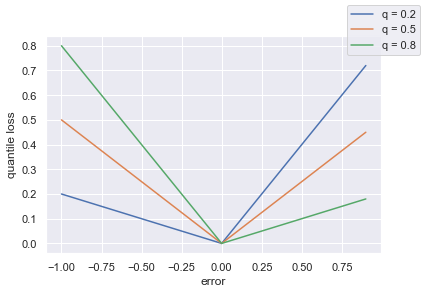

In [40]:
def quantile_loss(q, y, f):
  # q: Quantile to be evaluated, e.g., 0.5 for median.
  # y: True value.
  # f: Forecast value.
  e = y - f
  return np.maximum(q * e, (q - 1) * e)

y_hat = np.arange(start=-1,stop=1,step=0.1)
y_test = np.zeros(len(y_hat))
error = y_hat - y_test

fig, ax = plt.subplots()
ax.plot(error, quantile_loss(0.2, y_test, y_hat), label = "q = 0.2")
ax.plot(error, quantile_loss(0.5, y_test, y_hat), label = "q = 0.5")
ax.plot(error, quantile_loss(0.8, y_test, y_hat), label = "q = 0.8")
ax.set(xlabel="error",ylabel="quantile loss")
fig.legend()
plt.show()

### Another important score is the continuous ranked probability score (CRPS). Its definition is such that it generalizes to the MAE if we replace the probabilistic forecast with a deterministic one.
Like the pinball score, it is a so-called 'proper' score. In short, this is to say that the score has the property that truthtelling is the most rewarding strategy. The definition and a figure can be found in my licentiate thesis (p. 31):

In [42]:
%%html
<iframe src="http://www.diva-portal.org/smash/get/diva2:1256832/FULLTEXT01.pdf" width="950" height="750"></iframe>

### Now that we have seen the core of quantile regression (QR), let's apply it to the data we applied linear regression to and evaluate what we get.

In [43]:
import statsmodels.api as sm 
taus = np.arange(0.1,0.91,0.1) # Define the quantiles we wish to train and forecast
# Xtra_jitter = np.random.normal(1*Xtra,0.01) # Add some random noise to avoid singular matrix
quantreg = sm.QuantReg(y_train, X_train)  
y_hat_qr = np.vstack( [quantreg.fit(q=q, max_iter=10000).predict(X_test) for q in taus], ).T

In [44]:
# CRPS: (no need to understand this code)
import warnings
import properscoring as ps
def CRPS(ens,obs):

    if type(obs) is pd.Series:
        obs = obs.to_numpy()
    if type(ens) is pd.DataFrame:
        ens = ens.to_numpy()
    obs = np.reshape(obs, (len(obs),1))
    idx = np.c_[obs,ens]
    idx = ~np.isnan(idx).any(axis=1) # check rows with NaNs
    ens = ens[idx,:] # remove rows with NaNs
    obs = obs[idx]
    ens.sort(axis=1) # Make sure there's no quantile crossing
    
    lst = []
    for k in range(ens.shape[0]):
        lst.append(ps.crps_ensemble(obs[k,0], ens[k]))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        return lst,np.nanmean(lst)

In [45]:
y_test = dat.loc['2016-02-01':'2016-12-31', 'dw_solar']
idx = y_test.to_numpy().nonzero()[0] # Check the non-zero values and disregard the rest

print("CRPS =",CRPS(y_hat_qr[idx,:],y_test[idx])[1])
print("Quantile score =",np.mean([quantile_loss(q,y_test[idx],y_hat_qr[idx,f]) for q,f in zip(taus,range(9))]))

CRPS = 32.309269870391624
Quantile score = 17.223671503268733


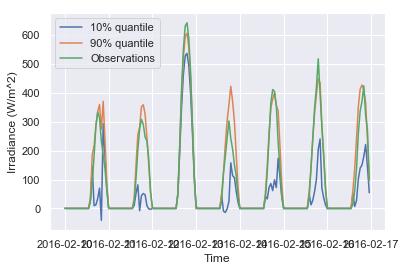

In [63]:
ens = pd.DataFrame(y_hat_qr, index=y_test.index)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.plot(ens.loc['2016-02-10':'2016-02-16',0], label = "10% quantile")
ax.plot(ens.loc['2016-02-10':'2016-02-16',8], label = "90% quantile")
ax.plot(y_test['2016-02-10':'2016-02-16'], label = "Observations")

ax.set(xlabel='Time', ylabel='Irradiance (W/m^2)')
ax.legend()
ax.figsize=(15, 13)
plt.show()

### It seems that the forecasts are better than those of the linear regression model (remember: CRPS allows for comparison with MAE of deterministic forecasts).
Unfortunately, numerical scores only tell part of the story and we therefore have to look at the distribution of our forecasts to see if they are well $\textit{calibrated}$. We can do this using the reliability diagram and the rank histogram. These visual verification tools allow us to determine whether the forecast distribution is, on average, indistinguishable from the distribution of the observations. Let's look at some examples with simulated data first and then continue with our forecast results.

In [64]:
# Define some functions that we'll use for forecast verification. There
# is no need to understand these.

from scipy.stats import binom
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
from statistics import mean
import properscoring as ps
import pandas as pd
import warnings

def quantile_loss(q, y, f):
  # q: Quantile to be evaluated, e.g., 0.5 for median.
  # y: True value.
  # f: Fitted (predicted) value.
  e = y - f
  return np.maximum(q * e, (q - 1) * e)

def interval_score(l, u, y, alpha):
    lst = []
    for i in range(len(y)):
        if y[i] < l[i]:
           lst.append((u[i] - l[i]) + 2/alpha * (l[i] - y[i]))
        elif y[i] > u[i]:
             lst.append((u[i] - l[i]) + 2/alpha * (y[i] - u[i]))
        else:
             lst.append((u[i] - l[i]))
    return lst

# Reliability diagram:
def reliabilityDiagram(ens,obs):
    if type(obs) is pd.Series:
        obs = obs.to_numpy()
    if type(ens) is pd.DataFrame:
        ens = ens.to_numpy()
    obs = np.reshape(obs, (len(obs),1))
    idx = np.c_[obs,ens]
    idx = ~np.isnan(idx).any(axis=1) # check rows with NaNs
    ens = ens[idx,:] # remove rows with NaNs
    obs = obs[idx]
    ens.sort(axis=1) # Make sure there's no quantile crossing
    
    taus = np.arange(0,1,(1/(ens.shape[1]+1)))
    taus = taus[1:len(taus)]
    res = np.zeros((ens.shape[1],4))
    res[:,3] = taus
    
    # Reliability:
    M_obs = np.repeat(obs,ens.shape[1],axis=1)
    res[:,0] = np.sum(M_obs < ens, axis = 0)/ens.shape[0]
     
    # Consistency bars:
    q_max = np.repeat(max(taus),ens.shape[1])
    q_min = np.repeat(min(taus),ens.shape[1])
    n = np.repeat(ens.shape[0], ens.shape[1])
    p = taus
    res[:,1] = binom.ppf(q_max,n,p)/ens.shape[0]
    res[:,2] = binom.ppf(q_min,n,p)/ens.shape[0]
        
    return res

def myPlot(reliabilityArray):
    
    fig = plt.figure()
    plt.plot(reliabilityArray[:,3], reliabilityArray[:,0], 'r', label = 'Reliability')
    plt.plot(reliabilityArray[:,3], reliabilityArray[:,3], 'k--', label = 'Ideal')
    plt.plot(reliabilityArray[:,3], reliabilityArray[:,1], 'grey', label = 'Upper bound')
    plt.plot(reliabilityArray[:,3], reliabilityArray[:,2], 'grey', label = 'Lower bound')
    plt.legend()
    return(fig)
    
    # Rank histogram:
def rankHistogram(ens,obs):
    if type(obs) is pd.Series:
        obs = obs.to_numpy()
    if type(ens) is pd.DataFrame:
        ens = ens.to_numpy()
    obs = np.reshape(obs, (len(obs),1))
    idx = np.c_[obs,ens]
    idx = ~np.isnan(idx).any(axis=1) # check rows with NaNs
    ens = ens[idx,:] # remove rows with NaNs
    obs = obs[idx]
    ens.sort(axis=1) # Make sure there's no quantile crossing
    
    z = np.zeros((ens.shape[0],1))
    ecdf = np.apply_along_axis(ECDF, 1, ens)
    for i in range(ens.shape[0]):
        z[i] = ecdf[i](obs[i])
    
    taus = np.arange(0,1,(1/(ens.shape[1]+1)))
    taus = taus[1:len(taus)]

    up = binom.ppf(max(taus), ens.shape[0], 1/(ens.shape[1]+1)) / ens.shape[0]
    down = binom.ppf(min(taus), ens.shape[0], 1/(ens.shape[1]+1)) / ens.shape[0]

    plt.hist(z, weights=np.ones(len(z)) / len(z))
    plt.hlines(1/(ens.shape[1]+1),colors='red',xmin=0,xmax=1,linestyles='--')
    plt.hlines(up,xmin=0,xmax=1,linestyles=':')
    plt.hlines(down,xmin=0,xmax=1,linestyles=':')
    
    # PINAW:
def PINAW(ens,obs,plot=True):
    if type(obs) is pd.Series:
        obs = obs.to_numpy()
    if type(ens) is pd.DataFrame:
        ens = ens.to_numpy()
    obs = np.reshape(obs, (len(obs),1))
    idx = np.c_[obs,ens]
    idx = ~np.isnan(idx).any(axis=1) # check rows with NaNs
    ens = ens[idx,:] # remove rows with NaNs
    obs = obs[idx]
    ens.sort(axis=1) # Make sure there's no quantile crossing    idx = ~np.isnan(idx).any(axis=1) # check rows with NaNs
            
    R = max(obs) - min(obs)
    nrows = int(np.floor(ens.shape[1]/2))
    PINAW = np.zeros(nrows)
    taus = np.arange(0,1,(1/(len(PINAW)+1)))
    taus = taus[1:len(taus)]
    taus = np.flip(taus)
    
    for c in range(nrows):
        PINAW[c] = (1/R) * mean(ens[:,(ens.shape[1]-1-c)] - ens[:,c])
        
    if plot == True:
        return plt.plot(taus,PINAW)
    elif plot == False:
        return pd.DataFrame({'tau':taus, 'PINAW':PINAW})
    
    # PICP:
def PICP(ens,obs):

    if type(obs) is pd.Series:
        obs = obs.to_numpy()
    if type(ens) is pd.DataFrame:
        ens = ens.to_numpy()
    obs = np.reshape(obs, (len(obs),1))
    idx = np.c_[obs,ens]
    idx = ~np.isnan(idx).any(axis=1) # check rows with NaNs
    ens = ens[idx,:] # remove rows with NaNs
    obs = obs[idx]
    ens.sort(axis=1) # Make sure there's no quantile crossing
    
    nrows = int(np.floor(ens.shape[1]/2))
    PICP = np.zeros((nrows,1))
    taus = np.arange(0,1,(1/(len(PICP)+1)))
    taus = taus[1:len(taus)]
    taus = np.flip(taus)
    
    for c in range(nrows):
        PICP[c,] = sum(sum((ens[:,c]<=obs.T) & (ens[:,(ens.shape[1]-1-c)] >= obs.T))) / ens.shape[0]
    
    plt.plot(taus,PICP, 'red', label = 'PICP')
    plt.plot(taus,taus, 'k--', label = 'Ideal')
    plt.legend()

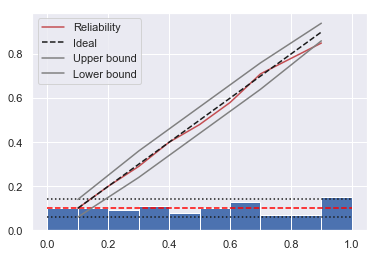

In [72]:
# Generate random data from standard normal distribution:
ens = np.random.normal(0,1,size=(100,9)) # Random ensemble forecast vector
obs = np.random.normal(0,1,size=(100,1)) # Random observation vector
myPlot(reliabilityDiagram(ens,obs))
rankHistogram(ens,obs)

It is interesting to note that it is still possible we observe non-reliable forecasts, even though the observations and forecasts come from the same distribution. This is due to the randomness in data sets of limited length and is why we have drawn upper and lower bounds. Regardless, it can still happen that the forecasts are considered unreliable and it is therefore important to have a test set of considerable length.

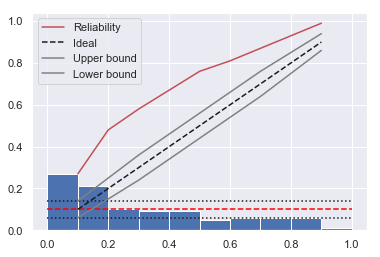

In [74]:
# Generate random data from standard normal distribution with biased forecast:
ens = np.random.normal(0.75,1,size=(100,9)) # Random ensemble forecast vector
obs = np.random.normal(0,1,size=(100,1)) # Random observation vector
myPlot(reliabilityDiagram(ens,obs))
rankHistogram(ens,obs)

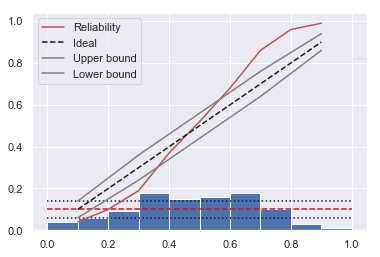

In [77]:
# Generate random data from standard normal distribution with unbiased but overdispersed forecast:
ens = np.random.normal(0,2,size=(100,9)) # Random ensemble forecast vector
obs = np.random.normal(0,1,size=(100,1)) # Random observation vector
myPlot(reliabilityDiagram(ens,obs))
rankHistogram(ens,obs)

### These were some examples of what type of deficiencies we might encounter, which we could not have identified by simply looking at the CRPS or quantile score.
Let's continue our visual inspection with the probabilistic forecasts on the irradiance data meauserd in Sioux Falls, South Dakota.

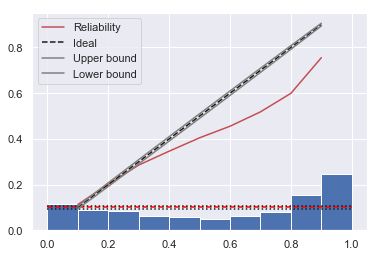

In [78]:
myPlot(reliabilityDiagram(y_hat_qr[idx,:],y_test[idx]))
rankHistogram(y_hat_qr[idx,:],y_test[idx])

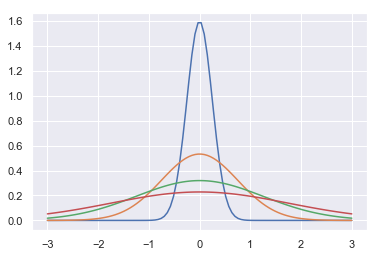

In [79]:
# Show sharpness in normal distribution.
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
x = np.linspace(-3,3,100)
for i in np.arange(0.25,2,0.5):
    plt.plot(x, stats.norm.pdf(x, mu, i))
plt.show()

In [82]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(std):
    mu = 0
    x = np.linspace(-3,3,100)
    plt.plot(x, stats.norm.pdf(x, mu, std))
    plt.show()

interactive_plot = interactive(f, std=np.arange(0.25,2,0.25))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(Dropdown(description='std', options=(0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75), value=0.25)…

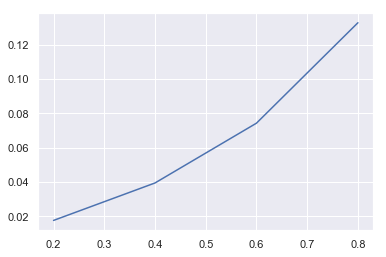

In [83]:
PINAW(y_hat_qr[idx,:],y_test[idx])

### Even though we produce sharp probabilistic forecasts, we still underestimate the irradiance by quite a lot, which makes sense in a way, because we're only relying on biased NWP inputs. The quantile regression model is unable to properly correct the bias.
Let's see if we can further improve these forecasts by applying a non-linear model such as quantile regression forests (QRFs). For that, we need a brief introduction to decision trees and random forests. A decision tree is a very intuitive predictive model that has low bias but high variance. The cool thing about it is that it is pure arithmetic.

In [84]:
%%html
<iframe src="https://en.wikipedia.org/wiki/Decision_tree" width="950" height="500"></iframe>

In [85]:
%%html
<iframe src="https://en.wikipedia.org/wiki/Random_forest" width="950" height="500"></iframe>

### The main difference between random forests and quantile regression forests is that instead of outputting the mean of the observations in an end node, it outputs the cumulative distribution function (CDF).
Scikit-learn has an implementation of the random forest algorithm, while Scikit-garden offers the quantile regression forest algorithm. Even though the model is quite robust in terms of hyperparameter selection, it's still a good exercise to perform cross-validation and find the optimal (in terms of, e.g., CRPS) hyperparameters. In order to do that efficiently, we need to define a few functions.

In [ ]:
# Declare the quantile regression forest model with its hyperparameters
from skgarden import RandomForestQuantileRegressor
from sklearn.model_selection import TimeSeriesSplit
import itertools 
import pandas as pd
import numpy as np
import properscoring as ps

def qrf(params):
    min_samples_split, min_samples_leaf, max_features, max_depth, n_estimators = params
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_leaf = int(min_samples_leaf)
    min_samples_split = int(min_samples_split)
    model = RandomForestQuantileRegressor(random_state=0, 
                                          min_samples_split=min_samples_split,
                                          n_estimators=n_estimators,
                                          max_features = max_features,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          n_jobs = -1)
    return model

# Function to create a DF with every combination of hyperparameters
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [ ]:
# Define the cross-validation function that takes the potential parameters, X and y
def timeseriesCVscore(params,X,y):

    res = []
    taus = np.arange(0.1,0.91,0.1)
    my_tscv = TimeSeriesSplit(n_splits=4)

    # The time series CV function takes the training data X and determines the splits
    # so that we can train and test with a set of hyperparameters and evaluate the
    # robustness of these hyperparameters.
    for train_index, test_index in my_tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Score using CRPS
        model = qrf(params)
        test_pred = np.vstack( [model.fit(X_train, y_train).predict(X_test, quantile = 100*q) for q in taus], ).T
        res.append(CRPS(test_pred, y_test)[1])
        
    return(np.nanmean(res))

In [ ]:
# This takes around 10-15 minutes so let this run in advance

dat = pd.read_csv("/Users/Dennis/Desktop/SupplementaryMaterials/data/sxf_2015-2016.txt", delimiter = "\t",
                 header='infer')
dat['Time'] = pd.to_datetime(dat['Time']) # Make sure that pandas recognizes this as datetime
dat = dat.set_index('Time') # Set time column as the index (easier for plotting)
dat = dat.dropna(axis=0) # Remove the NaNs

# Define the training and test set:
X_train = dat.loc['2015-01-01':'2015-06-30', 'Ics':'G_nam'].reset_index().drop('Time', axis=1) # Because Time
y_train = dat.loc['2015-01-01':'2016-06-30', 'dw_solar'].reset_index().drop('Time', axis=1)

parameters_qrf = {
                        "min_samples_split": [3],
                        "min_samples_leaf": [1],
                        "max_features": [0.75, 0.5],
                        "max_depth":[8],
                        "n_estimators":[500,1500]
                 } 

parameters = expand_grid(parameters_qrf).values.tolist()
parameters_qrf = expand_grid(parameters_qrf)
    
results = [] # Store the CRPS results, the order agrees with the order in the parameter grid
for p in parameters:
    res = timeseriesCVscore(p,X_train.to_numpy(),y_train.values.ravel()) # Note that we do not use the test data here.
    results.append(res)
                
parameters_qrf['CRPS'] = pd.Series(results, index=parameters_qrf.index)

In [ ]:
print(parameters_qrf.sort_values(by=['CRPS'])) # Sort on CRPS

In [ ]:
type(parameters_qrf)

### Now that we have found the optimal hyperparameters, we can finally train and test.

In [ ]:
# This takes around 25 minutes so do this beforehand
taus = np.arange(0.1,0.91,0.1)
# Define the training and test set:
X_train = dat.loc['2015-01-01':'2016-01-31', 'Ics':'G_nam'].reset_index().drop('Time', axis=1) # Because Time
y_train = dat.loc['2015-01-01':'2016-01-31', 'dw_solar'].reset_index().drop('Time', axis=1)

X_test = dat.loc['2016-02-01':'2016-12-31', 'Ics':'G_nam'].reset_index().drop('Time', axis=1) # Because Time
y_test = dat.loc['2016-02-01':'2016-12-31', 'dw_solar']

params = parameters_qrf.iloc[0,:].drop(['CRPS']) # Take the best model parameters

model = qrf(params) # Initiate the model with the optimal parameters
y_hat_qrf = np.vstack( [model.fit(X_train.to_numpy(), y_train.values.ravel()).predict(X_test.to_numpy(), quantile = 100*q) for q in taus], ).T
idx = y_test.to_numpy().nonzero()[0] # Check the non-zero values and disregard the rest

print("CRPS =",CRPS(y_hat_qrf[idx,:],y_test[idx])[1])
print("Quantile score =",np.mean([quantile_loss(q,y_test[idx],y_hat_qrf[idx,f]) for q,f in zip(taus,range(9))]))

In [ ]:
# Take the verification plots of the quantile regression model for comparison:
myPlot(reliabilityDiagram(y_hat_qr[idx,:],y_test[idx]))
rankHistogram(y_hat_qr[idx,:],y_test[idx])

In [ ]:
myPlot(reliabilityDiagram(y_hat_qrf[idx,:],y_test[idx]))
rankHistogram(y_hat_qrf[idx,:],y_test[idx])

### Note how much we have been able to improve the bias of the forecasts. More elaborate cross-validation could easily improve this further but at the cost computational time.

### Another helpful feature of decision tree type algorithms is the so-called variable importance. In short, due to its setup, it allows us to visually inspect the variables that were helpful in predicting (irradiance in this case) and random forests are therefore said to be robust to irrelevant variables.

In [ ]:
# Code from: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### A few words on benchmarks for probabilistic forecasts
The probabilistic extension of the persistence benchmark $(\hat{y}_{t+h} = y_t)$ would take the last $N$ observations and sort these to form a distribution. However, the choice of $N$ leads to different results and the persistence ensemble (PeEn) is therefore ambiguous because it has skill. The climatology is the most common benchmark in the atmospheric sciences and it is a forecast of the entire distribution of the dependent variable (e.g., irradiance, temperature, etc.).

Recently, benchmarks have been proposed specifically for irradiance (Yang, 2019) and the clear-sky index (Munkhammar et al., 2019).

The benchmark by Yang (complete history persistence ensemble, CH-PeEn) takes only time of day into consideration and forecasts the historical distribution of observations at that time of day.

The benchmark by Munkhammar et al. (Markov-chain mixture model, MCM) is more advanced and estimates a transition matrix, which is conditioned with the latest observation, which then produces a piece-wise uniform distribution.

More details can be found in the hand-outs.

# Ingesting, cleaning and organizing data.

The datasets we have used until now have been downloaded elsewhere. These data have either been cleaned by the people maintaining the sensor network or the scientists that published them online. However, we can also try to do this ourselves. After all, data ingestion and analysis is probably the most time consuming part of a machine learning task!  

For this example, we'll look at atmospherical data from the AROME model, maintained by the Norwegian meteorological institute. This dataset has fewer dimensions than the one we are interested, namely the MetCoOp Ensemble Prediction System (MEPS), which is jointly run in operational routing by the Norwegian, Swedish and Finnish meteorological institutes. It consists of 10 ensemble members, has a horizontal resolution of 2.5 km, 65 vertical levels. MEPS is run 4 times a day at hourly resolution and produces forecasts up to 66 hours ahead.

In the following, we first look at data from the AROME model to get an idea of the type of data we are dealing with and then continue with the MEPS forecasts. We'll download data for a few days and make some plots to see if what we observe makes sense.

In [86]:
%%html
<iframe src="http://thredds.met.no/thredds/catalog/aromearcticlatest/catalog.html" width="950" height="500"></iframe>

In [87]:
from netCDF4 import Dataset as NetCDFFile

# Read in netcdf file, the original can be found here: 
# http://thredds.met.no/thredds/catalog/aromearcticlatest/catalog.html

url ='http://thredds.met.no/thredds/dodsC/aromearcticlatest/arome_arctic_extracted_2_5km_latest.nc'
nc = NetCDFFile(url)
# Variables
t2m = nc.variables['air_temperature_2m'][:]

In [88]:
from sys import getsizeof
print(getsizeof(nc)) # in bytes
print(getsizeof(t2m))

240
168


In [89]:
print(nc)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    Conventions: CF-1.6
    institution: Norwegian Meteorological Institute, MET Norway
    creator_url: met.no
    summary: AROME_Arctic is a convection-permitting atmosphere model covering parts of the Barents Sea and the Nordic Arctic. It has horizontal resolution of 2.5 km and 65 vertical levels. AROME_Arctic runs for 66 hours four times a day (00,06,12,18) with three-hourly cycling for data assimilation. Boundary data is from ECMWF. Model code based on HARMONIE cy40h1.1
    source: AROME_Arctic 2.5km
    title: AROME_Arctic 2.5km
    min_time: 2019-09-02 06:00:00Z
    max_time: 2019-09-05
    geospatial_lat_min: 62.0
    geospatial_lat_max: 88.0
    geospatial_lon_min: -18.0
    geospatial_lon_max: 80.0
    references: unknown
    license: https://www.met.no/frie-meteorologiske-data/lisensiering-og-kreditering
    comment: none
    history: 2019-09-02 creation by fimex
    DODS_EXTRA.Unli

In [90]:
# Get specific coordinates from nc so that I know where to find UU:
lat = nc.variables['latitude'][:] # (y,x) for some reason (latlon)
np.shape(lat)

(949, 739)

In [91]:
# Get specific coordinates from nc so that I know where to find UU:
lon = nc.variables['longitude'][:] # (y,x) for some reason
np.shape(lon)

(949, 739)

In [92]:
import numpy as np
print(np.shape(t2m))

(67, 1, 949, 739)


In [93]:
# Function that returns the indices of the point closest to "value"
def find_nearest(array, value):
    X = np.abs(array - value)
    idx = np.where( X == X.min() )
    return idx

In [94]:
# I think the following is correct. Assuming latitude is y and longitude is x, 
# we find the y-coordinate of the latitude and the x-coordinate of the longitude.
# I checked it with the latlon plots and t2m and it seems to be correct.

# t2m at coordinate closest to 90,-30 for all forecast horizons (67 in total):
np.asarray(t2m[:,0,find_nearest(lat, 90)[0],find_nearest(lon, -30)[1]][0:2])

array([[270.95728],
       [271.29248]], dtype=float32)

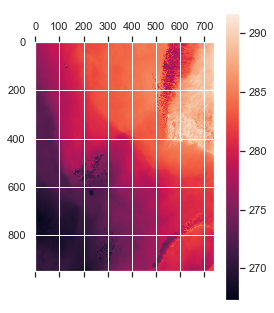

In [95]:
import matplotlib.pyplot as plt
import numpy as np
# Display matrix
#plt.matshow(lat)
#plt.matshow(lon)
plt.matshow(t2m[0,0,:,:])
plt.colorbar()
plt.show()

### Now do the same but then with MEPS data, which has 10 ensemble members. Let's try to take a week's worth of data and store it in a matrix/dataframe. 
The variables of interest are cloud cover fraction [cloud_area_fraction(time,height0,ensemble_member,y,x)] and surface irradiance []. I don't exactly know which the latter is so let's stick to air temperature 2m above ground [air_temperature_2m(time,height1,ensemble_member,y,x)].

In [96]:
# Now with data that's of interest to me:

from netCDF4 import Dataset as NetCDFFile
# Read in netcdf file
url = 'http://thredds.met.no/thredds/dodsC/meps25epsarchive/2018/06/01/meps_full_2_5km_20180601T00Z.nc'
nc = NetCDFFile(url)

In [97]:
print(nc)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    Conventions: CF-1.6
    institution: Norwegian Meteorological Institute, MET Norway
    creator_url: met.no
    summary: MEPS (MetCoOp-Ensemble Prediction System) is a convection-permitting atmosphere ensemble model covering Scandinavia and the Nordic Seas. It has horizontal resolution of 2.5 km, has 65 vertical levels and 10 members. MEPS is ran four times daily (00,06,12,18) with three-hourly cycling for data assimilation. Member 0 and 1 are ran up to 66 hours, the rest up to 48 hours. Boundary data is from ECMWF, and initial perturbations are based on the SLAF method. Model code based on HARMONIE cy40h1.1
    source: MEPS 2.5km
    title: MEPS 2.5km
    min_time: 2018-06-01 00:00:00Z
    max_time: 2018-06-03
    geospatial_lat_min: 51.0
    geospatial_lat_max: 88.0
    geospatial_lon_min: -20.0
    geospatial_lon_max: 80.0
    references: unknown
    license: https://www.met.no/en/free-

In [98]:
# Function that returns the indices of the point closest to "value"
def find_nearest(array, value):
    X = np.abs(array - value)
    idx = np.where( X == X.min() )
    return idx

# Extracting the coordinates only needs to be done once:
from netCDF4 import Dataset as NetCDFFile
url = 'http://thredds.met.no/thredds/dodsC/meps25epsarchive/2018/06/01/meps_extracted_2_5km_20180601T00Z.nc'
nc = NetCDFFile(url)
lat = nc.variables['latitude'][:] # (y,x) for some reason --> (latlon)
lon = nc.variables['longitude'][:] # (y,x) for some reason

In [99]:
# Let's combine the above into a loop and cbind it into a list
# The idea is to extract air temperature, cloud area fraction and time
# and store these in lists. Afterwards, combine these into a DF.
# Do this for M ensemble members, H forecast horizons and d days.

from netCDF4 import Dataset as NetCDFFile
import numpy as np
import pandas as pd
import datetime

M = 5  # Ensemble members
H = 24 # Forecast horizon

lst_time = []
lst_temp = []
lst_tcc = []

latitude = 59.858227
longitude = 17.632252

#days = ["01", "02", "03", "04", "05"]
days = ["01", "02", "03", "04"]
for d in days:
    url = 'http://thredds.met.no/thredds/dodsC/meps25epsarchive/2018/06/' + d + '/meps_extracted_2_5km_201806' + d + 'T00Z.nc'
    nc = NetCDFFile(url)
    # Temperature:
    t2m = nc.variables['air_temperature_2m'][0:H,0,0:M,find_nearest(lat, latitude)[0],find_nearest(lon, longitude)[1]]
    temperature = np.reshape(np.asarray(t2m), (H,M))
    lst_temp.append(temperature)
    # Cloud cover:
    tcc = nc.variables['cloud_area_fraction'][0:H,0,0:M,find_nearest(lat, latitude)[0],find_nearest(lon, longitude)[1]]
    cloud = np.reshape(np.asarray(tcc), (H,M))
    lst_tcc.append(cloud)
    # Time:
    time = nc.variables['time'][0:H]
    tme = [pd.to_datetime(datetime.datetime.fromtimestamp(np.asarray(i)), utc=True) for i in time]
    lst_time.append(tme)
        

In [100]:
mydf = pd.DataFrame(data=np.hstack((np.vstack(lst_temp),np.vstack(lst_tcc))), index = np.vstack(lst_time).flatten())
mydf

,0,1,2,3,4,5,6,7,8,9
2018-06-01 02:00:00+00:00,283.789551,283.892578,2.844404e+02,283.659180,284.610352,0.000031,0.000031,3.051781e-05,0.000031,0.000046
2018-06-01 03:00:00+00:00,282.970947,283.254883,2.838850e+02,282.708252,284.302246,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2018-06-01 04:00:00+00:00,282.565918,282.875732,2.833884e+02,282.272949,283.843994,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2018-06-01 05:00:00+00:00,282.692627,283.018311,2.834822e+02,282.469971,283.824219,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2018-06-01 06:00:00+00:00,283.944824,284.325684,2.847397e+02,283.932373,284.929199,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2018-06-01 07:00:00+00:00,286.045410,286.471436,2.867703e+02,286.115723,286.758301,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2018-06-01 08:00:00+00:00,288.392578,288.892090,2.891250e+02,288.374512,288.820068,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2018-06-01 09:00:00+00:00,290.708008,291.352295,2.915063e+02,290.648193,291.007568,0.000000,0.000885,0.000000e+00,0.000000,0.000000
2018-06-01 10:00:00+00:00,292.927246,293.638428,2.939409e+02,292.800781,293.084961,0.000000,0.451172,0.000000e+00,0.000031,0.000000
2018-06-01 11:00:00+00:00,294.745361,295.562500,2.958955e+02,294.547363,294.906982,0.000000,0.100067,0.000000e+00,0.845581,0.000000


In [101]:
# Alright, we have quite a few nonsensical values. Let's replace those with NaNs so we can interpolate them.
tmp = mydf.where(mydf < 1000) # Replace values that are higher than 1000 with NaNs. Replace this with a reasonable limit for you variables.
tmp.interpolate(method='linear', axis=1, inplace=True)

/Users/Dennis/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


Text(0, 0.5, 'Temperature (K)')

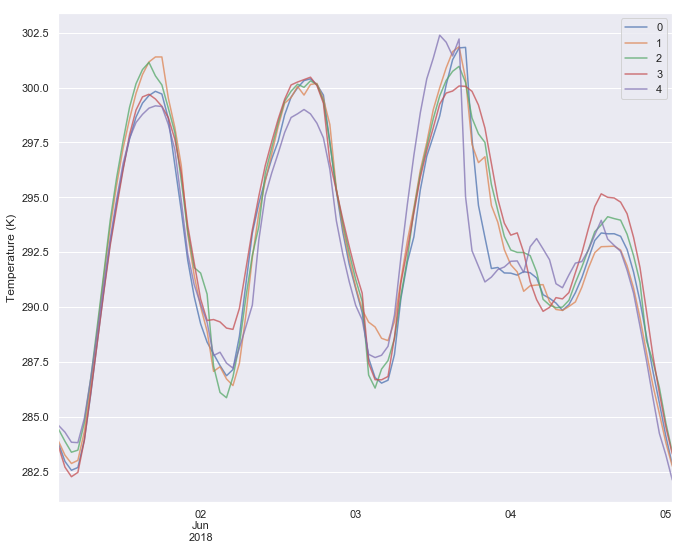

In [102]:
# Let's plot the results:
import matplotlib.pyplot as plt
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = [0, 1, 2, 3, 4] # Ensemble member 2 predicts a temperature of 9.96e+36 K, very uncommon in Sweden! ;) 
axes = tmp[cols_plot].plot(alpha=0.75, figsize=(11, 9), subplots=False)
axes.set_ylabel('Temperature (K)')

In [103]:
mydf.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [104]:
tmp.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64